# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [1]:
from panel.interact import interact


Bad key "text.kerning_factor" on line 4 in
C:\Users\graci_qcplqsz\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [33]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

coordinates_file_path = Path("Data/neighborhoods_coordinates.csv")
coordinates_df = pd.read_csv(coordinates_file_path)


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [89]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    mean_housing_units = sfo_data.groupby('year').mean()['housing_units']
    tbl = mean_housing_units.describe()
    yaxis_lower = round(tbl[3]-tbl[2])
    yaxis_upper = round(tbl[7]+tbl[2])

    units_ax = mean_housing_units.plot(kind='bar',title='Housing Units in San Francisco from 2010 to 2016',rot=90)
    units_ax.set_xlabel("Year")
    units_ax.set_ylabel("Housing Units")
    units_ax.set_ylim(yaxis_lower,yaxis_upper)
    
    plt.close()
    return pn.panel(units_ax.figure)



def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    sfo_data_grp = sfo_data[['sale_price_sqr_foot','gross_rent']]
    avg_price_rent = sfo_data_grp.groupby("year").mean()

    ax_avg_rent = avg_price_rent['gross_rent'].plot(title="Average Gross Rent by Year",color="red")
    ax_avg_rent.set_xlabel("Year")
    ax_avg_rent.set_ylabel("Price per SqFt")
    
    plt.close()
    return pn.panel(ax_avg_rent.figure)




def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_data_grp = sfo_data[['sale_price_sqr_foot','gross_rent']]
    avg_price_rent = sfo_data_grp.groupby("year").mean()

    ax_avg_price = avg_price_rent['sale_price_sqr_foot'].plot(title="Average Price per SqFt by Year",color="purple")
    ax_avg_price.set_xlabel("Year")
    ax_avg_price.set_ylabel("Price per SqFt")
    
    plt.close()
    return pn.panel(ax_avg_price.figure)



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    new_sfo_data = sfo_data.reset_index()
    avg_neighborhood_grp = new_sfo_data[['year','neighborhood','sale_price_sqr_foot','housing_units','gross_rent']]
    avg_neighborhood_grp = avg_neighborhood_grp.groupby(['year','neighborhood']).mean().reset_index()

    sale_price_plot = avg_neighborhood_grp.hvplot.line(
        "year",
        "sale_price_sqr_foot",
        xlabel="Year",
        ylabel="Avg. Sale Price per Square Foot",
        groupby="neighborhood",
        )

    return pn.panel(sale_price_plot)
    
    
    
def average_rent_by_neighborhood():
    """Average Gross Rent by Neighborhood."""
    new_sfo_data = sfo_data.reset_index()
    avg_neighborhood_grp = new_sfo_data[['year','neighborhood','sale_price_sqr_foot','housing_units','gross_rent']]
    avg_neighborhood_grp = avg_neighborhood_grp.groupby(['year','neighborhood']).mean().reset_index()
   
    gross_rent_plot = avg_neighborhood_grp.hvplot.line(
        "year",
        "gross_rent",
        xlabel="Year",
        ylabel="Avg. Gross Rent per Year",
        groupby="neighborhood",
    )

    return pn.panel(gross_rent_plot)



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    neighborhood_grp = sfo_data.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).reset_index()
    top10_neighborhood_grp = neighborhood_grp[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].head(10)
    top10_neighborhood_grp_plot = top10_neighborhood_grp[['sale_price_sqr_foot','neighborhood']].hvplot.bar(
        rot=90,title='Top 10 Expensive Neighborhoods in SFO',
        x='neighborhood',xlabel='Neighborhood',
        ylabel="Avg Sale Price per Square Foot",height=400)

    return pn.panel(top10_neighborhood_grp_plot)



def neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Neighborhoods."""   

    new_sfo_data = sfo_data.reset_index()
    avg_neighborhood_grp = new_sfo_data[['year','neighborhood','sale_price_sqr_foot','housing_units','gross_rent']]
    avg_neighborhood_grp = avg_neighborhood_grp.groupby(['year','neighborhood']).mean().reset_index()

    rent_v_price_plot = avg_neighborhood_grp.hvplot.bar(
        x='year', y=['gross_rent','sale_price_sqr_foot'],groupby='neighborhood',
        xlabel='Neighborhood',ylabel='Num Housing Units',
        title='Cost to Purchase v Rental Income',
        stacked=False,rot=90,height=450)
    
    return pn.panel(rent_v_price_plot)
    

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    neighborhood_grp = sfo_data.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).reset_index()
    top10_neighborhood_grp = neighborhood_grp[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].head(10)

    prices_df = sfo_data.groupby('neighborhood').mean().reset_index()
    df_expensive_neighborhoods_per_yr = prices_df[prices_df["neighborhood"].isin(top10_neighborhood_grp["neighborhood"])]
    df_expensive_neighborhoods_per_yr_sorted = df_expensive_neighborhoods_per_yr.sort_values('sale_price_sqr_foot',ascending=False).round(2)

    para_coord_plot = px.parallel_coordinates(df_expensive_neighborhoods_per_yr_sorted,
                        dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
                        color='sale_price_sqr_foot',
                        title='Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods')
    
    return pn.panel(para_coord_plot)
    


def parallel_categories():
    """Parallel Categories Plot."""
    neighborhood_grp = sfo_data.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).reset_index()
    top10_neighborhood_grp = neighborhood_grp[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].head(10)

    prices_df = sfo_data.groupby('neighborhood').mean().reset_index()
    df_expensive_neighborhoods_per_yr = prices_df[prices_df["neighborhood"].isin(top10_neighborhood_grp["neighborhood"])]
    df_expensive_neighborhoods_per_yr_sorted = df_expensive_neighborhoods_per_yr.sort_values('sale_price_sqr_foot',ascending=False).round(2)

    para_cat_plot = px.parallel_categories(df_expensive_neighborhoods_per_yr_sorted,
                       dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
                       color='sale_price_sqr_foot',
                       title='Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods')

    return pn.panel(para_cat_plot)



def neighborhood_map():
    """Neighborhood Map."""

    prices_df = sfo_data.groupby('neighborhood').mean().reset_index()
    joined_data = pd.concat([coordinates_df,prices_df],axis="columns", join="inner")
    px.set_mapbox_access_token(map_box_api)

    map_plot_price = px.scatter_mapbox(
        joined_data,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        zoom=11,
        title='Average Sale Price per Square Foot and Gross Rent in San Francisco')

    return pn.panel(map_plot_price)



def sunburst():
    """Sunburst Plot."""
    new_prices_df = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    neighborhood_grp = sfo_data.groupby('neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False).reset_index()
    top10_neighborhood_grp = neighborhood_grp[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].head(10)

    df_expensive_neighborhoods_per_yr = new_prices_df[new_prices_df["neighborhood"].isin(top10_neighborhood_grp["neighborhood"])]
    sunburst_plot = px.sunburst(df_expensive_neighborhoods_per_yr,
            path=['year','neighborhood'],values='sale_price_sqr_foot',
            color='gross_rent',color_continuous_scale='blues',
            title='Cost Analysis of Most Expensive neighborhoods in San Francisco per Year',
            height=700)
    
    return pn.panel(sunburst_plot)


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [127]:
# Create a Title for the Dashboard
title = "# San Francisco Property Overview"
subtitle = "### This interactive overview of the San Francisco property market is to assist current and potential property investors.  It reviews neighborhood trends, and compares sales & rental prices over recent years."
subtitle2 = "#### Brought to you by Grace Ho, May 2021"

# Create a tab layout for the dashboard

sfo_overview_title = "### San Francisco Market Overview"
sfo_overview_subtitle = "This interactive map provides an overview of prices per square foot and gross rents."
sfo_overview_subtitle2 = "Housing Units in the SFO area are shown below."

price_overview_title = "### A comparison of overall San Francisco price per square foot and gross rent over recent years"
neighborhood_overview_title = "### Select from the drop down list to compare prices in your desired neighborhood"
prestige_title = "### San Francisco's Top 10 prestige neighborhoods"
prestige_subtitle = "Hover over the graphs to see further details."
attribute_title = "### An interactive breakdown of key property attributes"
attribute_subtitle = "Drag columns or lines to adjust your view."

sfo_overview_col = pn.Column(sfo_overview_title,sfo_overview_subtitle,neighborhood_map,sfo_overview_subtitle2,housing_units_per_year)
price_overview_col = pn.Column(price_overview_title,average_sales_price,average_gross_rent)
neighborhood_overview_col = pn.Column(neighborhood_overview_title,neighborhoods_rent_sales,average_price_by_neighborhood,average_rent_by_neighborhood)
prestige_col = pn.Column(prestige_title,prestige_subtitle,sunburst,top_most_expensive_neighborhoods)
attribute_col = pn.Column(attribute_title,attribute_subtitle,parallel_categories,parallel_coordinates)

tabs = pn.Tabs(
    ("Market Overview", sfo_overview_col),
    ("Price Overview", price_overview_col),
    ("Neighborhood Overview", neighborhood_overview_col),
    ("Prestige Areas", prestige_col),
    ("Attribute Analysis", attribute_col))

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Markdown(str)
    [3] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure)
            [3] Markdown(str)
            [4] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
        [1] Column
            [0] Markdown(str)
            [1] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
        [2] Column
            [0] Markdown(str)
            [1] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
            [2] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
            [3] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
        [3] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure)
            [3] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Bars)
        [4] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure)
            [3] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure)
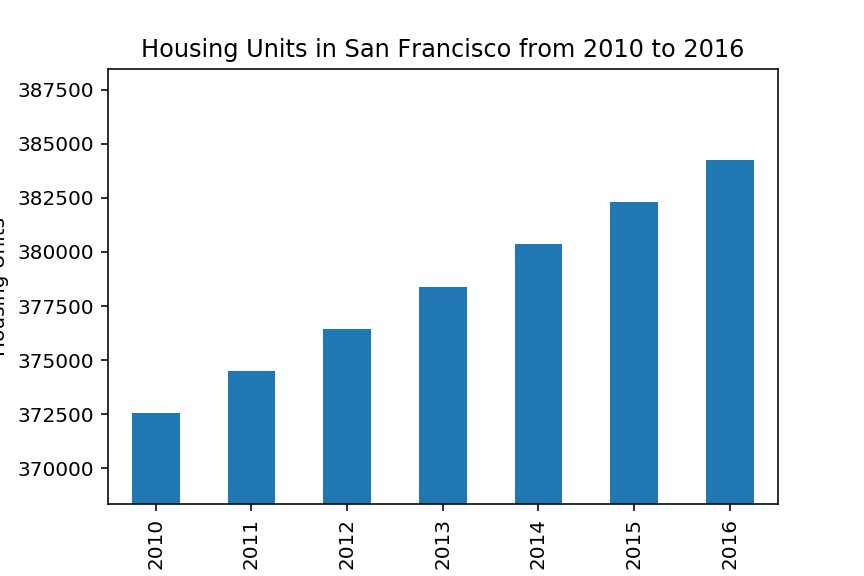
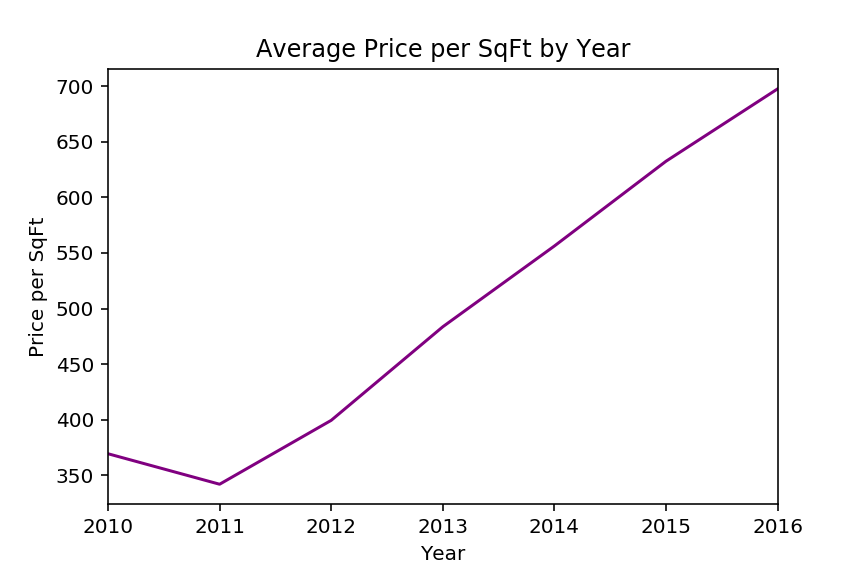
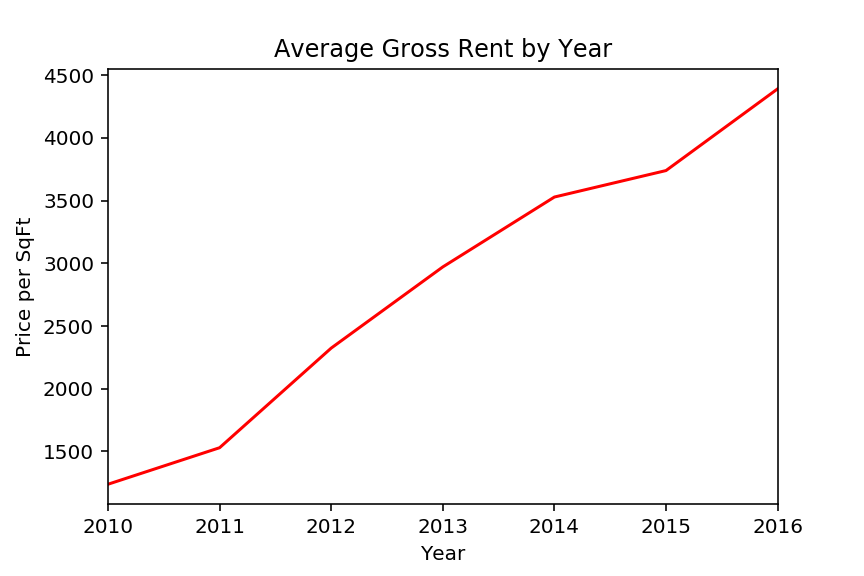

In [128]:
# Create the dashboard
dashboard = pn.Column(
    title,
    subtitle,
    subtitle2,
    tabs)
dashboard

## Serve the Panel Dashboard

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Markdown(str)
    [3] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, relayout_data={'autosize': True})
            [3] Markdown(str)
            [4] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
        [1] Column
            [0] Markdown(str)
            [1] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Matplotlib(Figure)
        [2] Column
            [0] Markdown(str)
            [1] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
            [2] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
            [3] Column
                [0] Column()
                [1] Row
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
        [3] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, relayout_data={'autosize': True})
            [3] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Bars)
        [4] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, relayout_data={'autosize': True})
            [3] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, relayout_data={'autosize': True})
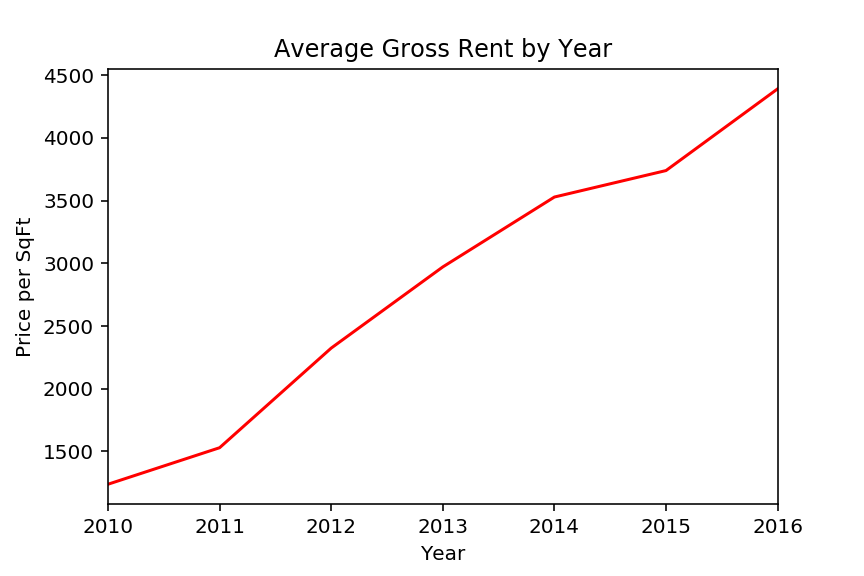
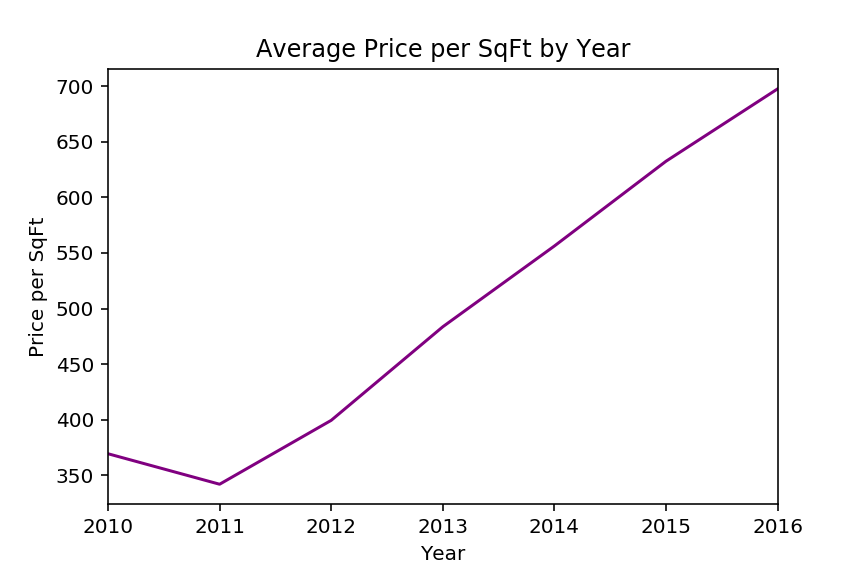
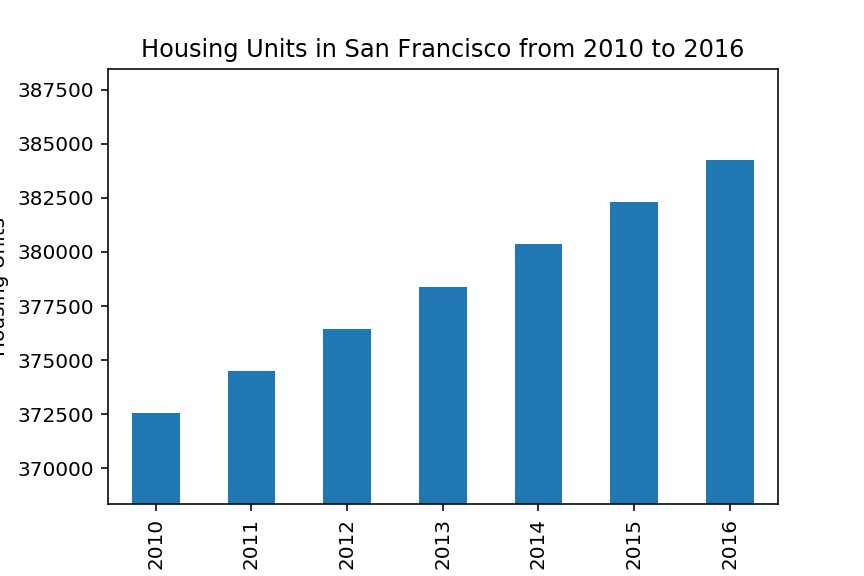

In [129]:
# Serve the# dashboard
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
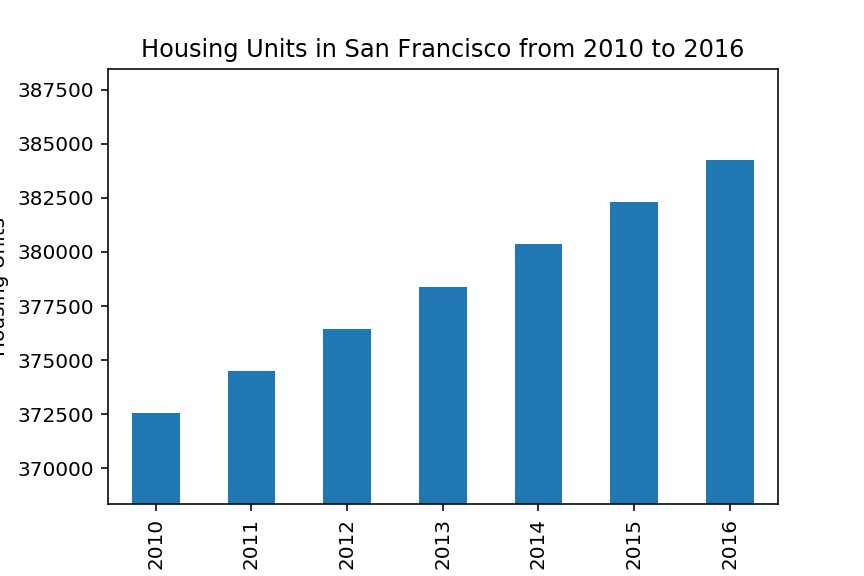

In [99]:
housing_units_per_year()

Str(AxesSubplot)

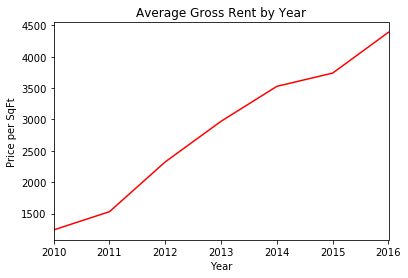

In [44]:
average_gross_rent()

Str(AxesSubplot)

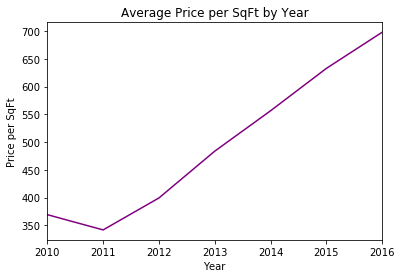

In [42]:
average_sales_price()

In [45]:
average_price_by_neighborhood()

Row
    [0] HoloViews(DynamicMap)
    [1] Column
        [0] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
        [1] VSpacer()

In [46]:
average_rent_by_neighborhood()

Row
    [0] HoloViews(DynamicMap)
    [1] Column
        [0] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
        [1] VSpacer()

In [47]:
top_most_expensive_neighborhoods()

HoloViews(Bars)

In [58]:
neighborhoods_rent_sales()

Row
    [0] HoloViews(DynamicMap)
    [1] Column
        [0] WidgetBox
            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
        [1] VSpacer()

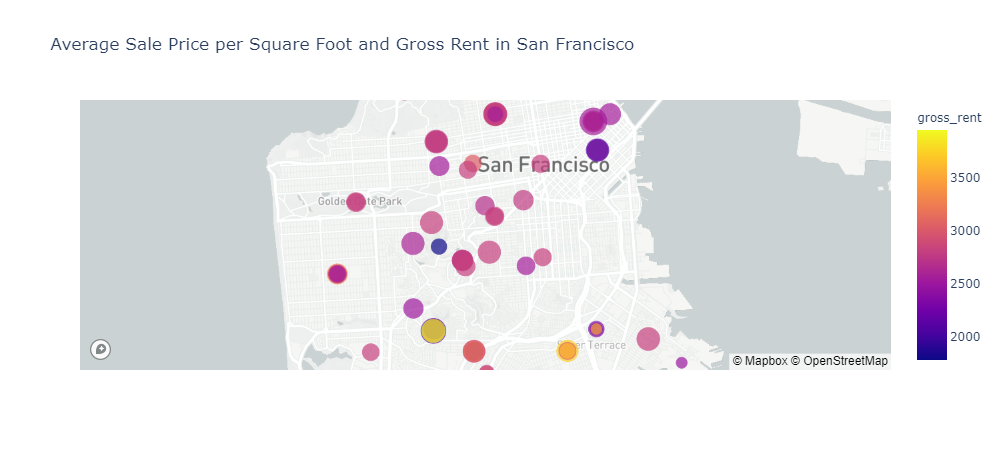

Launching server at http://localhost:56710


In [49]:
neighborhood_map().show()

In [50]:
parallel_categories()

Plotly(Figure)

In [51]:
parallel_coordinates()

Plotly(Figure)

In [52]:
sunburst()

Plotly(Figure)